In [1]:
import thinkplot
import thinkstats2
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy.stats as ss
import math

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,7)

<b>Note:</b> This was formally #16, we did a little reorganizing. 

<h1>Estimating the Height of a Population</h1>

We want to estimate the height of a population of people. We currently only have a sample of data. What do we do?
<br>
We can ESTIMATE the population using the sample. This is how we can generalize from a subset of data to draw conclusions about everyone, just like a pre-election poll or a survey. Our process will be:
<ul>
<li>Build a analtical distribution based on the values of our sample. 
<li>Use that analytical distribution to run a bunch of trials. 
<li>Use the aggregate of those trials to give an estimate of reality, along with error rates of how much we can trust that estimate.
</ul>

First, we will load and take a little preview of the data. 

In [2]:
#Read Data, make it inches for ease of viewing
df = pd.read_csv("data/h_w_scatter.csv")
df["height"] = df["height"]/2.54
df.head()

,weight,age,height,size
0,62,28.0,68.0,XL
1,59,36.0,66.0,L
2,61,34.0,65.0,M
3,65,27.0,69.0,L
4,62,45.0,68.0,M


##### Note on "Making a Distribution"

Here, when we say something like we are "making a distribution", we're referring to just generating an analytical distribution based on the stats from our data, usually mean and standard distribution. More specifically, we are doing that, then generating a set of random values that match that distribution. 

For example, this line of code generates 1,000 values that follow a normal distribution with a mean of 3 and a std of 1. You can graph it to see what it looks like. Try running it a few times over and over, each distribution will be similar, but slightly different. The higher the number of values, the more consistent it will be, the lower the number of values, the more varaition. Think about why...

Text(0.5, 1.0, 'Example of a Random Sample')

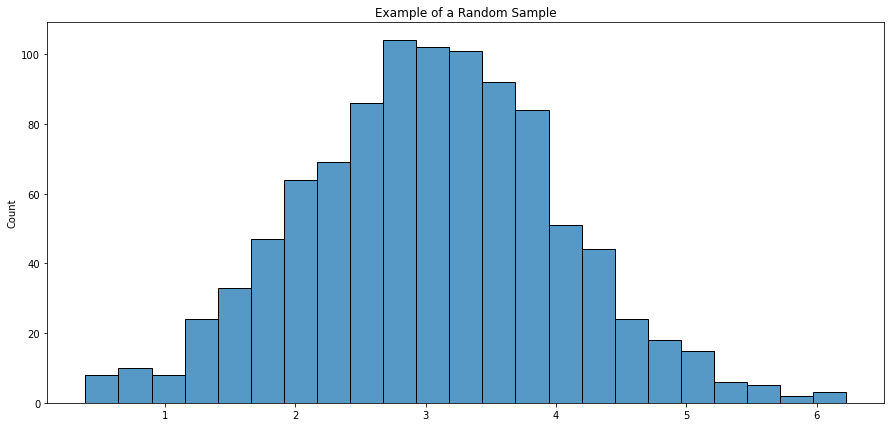

In [3]:
tmp_dist = np.random.normal(3, 1, 1000)
sns.histplot(tmp_dist)
plt.title("Example of a Random Sample")

### Back to our Data - Look at the Distribution

Plot the data. Here we combine the grid from thinkplot, with seaborn graphs - for maximum coolness. 

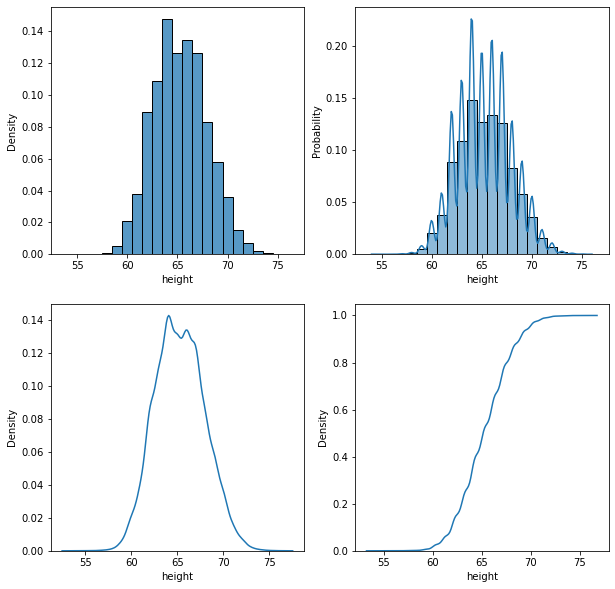

In [4]:
#Visualize - a few ways for fun!
# I'm just doing this for the hell of it, any distribution matching will work 
thinkplot.PrePlot(2,2,2)
sns.histplot(x="height", data=df, binwidth=1, discrete=True, stat="density")
thinkplot.SubPlot(2)
sns.histplot(x="height", data=df, kde=True, discrete=True, stat="probability")
thinkplot.SubPlot(3)
sns.kdeplot(x="height", data=df, bw_adjust=2)
thinkplot.SubPlot(4)
sns.kdeplot(x="height", data=df, cumulative=True)
thinkplot.Config()

In [5]:
#Get some stats on our data
df["height"].describe()

count    119404.000000
mean         65.277872
std           2.652619
min          54.000000
25%          63.000000
50%          65.000000
75%          67.000000
max          76.000000
Name: height, dtype: float64

<h2>Estimators, an Exploration</h2>

Our goal here is to <b>use what we have to estimate the average height of the population as a whole</b>. To do that we need to take some of our sample statistics and use them to create the estimation. How good are they?

We ideally want unbaised estimators, or ones that will trend towards having an error of 0 if given enough simulations. We can test this with an implementation of the estimation game from the book - here we just have a function that is customizable with any mu/sigma for a normal distribution. We can take our statistics, and run the estimation game over and over. If the average difference of the trial runs from the real sample values is small, we have pretty good estimators. 

We will implement the estimation game from the book. Below is very similar to what is in the first part of ch8. 

The normalEstimates function below does a few things:
<ul>
<li>Takes the stats from our data. 
<li>Generates a bunch of random numbers following a normal distribution based on that. 
<li>Tallys how close to the real data a bunch of stats of that distribution are.
</ul>

Think - if we were to create an estimated distribution, we'd probably want it to reflect the real data, on average. E.g. we wouldn't want the analytical distribution to have a mean that is always way larger or way smaller than the mean of our data. So, if we run a bunch of trial ones, the mean of the analytical trials should trend to be the same as the mean of our data, the median should trend to be the same as our data, the standard deviation, etc...

This step is strictly exploraatory - we are looking to see if we are introducing any bias/error into our estimation right off the bat. We can also use this to select our estimators. E.g. if the median tended to be less biased than the mean, we could (try to) use that to create the distribution. Or if we had some other reasoning (e.g. domain knowledge) we may look to have another estimator. The n-1 vs n argument is mostly academic, don't worry about it too much, the book has a few details, but largely refers to wikipedia for an explaination - we'll touch on this a little more later with hypothesis testing, it is more of a theoretical concern than a practical one. 

In practice, we'll probably just use the mean and standard deviation in most cases to create our distributions. 

In [6]:
def MeanError(estimates, actual):
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

##### Normal Estimates

This function just takes in a mean and standard deviation, generates "iters" normal distributions, then tallies up their basic statistics. 

In [7]:
#Estimations for a normal distribution
def normalEstimates(mu=0, median=0, sigma=1, n=1000, iters=1000):
    estimates1 = []
    estimates2 = []
    means = []
    medians = []
    for _ in range(iters):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        means.append(xbar)
        xmed = np.median(xs)
        medians.append(xmed)
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('mean error (biased) S2', MeanError(estimates1, sigma**2))
    print('mean error (unbaised) S2(n-1)', MeanError(estimates2, sigma**2))
    print('mean error means', MeanError(means, mu))
    print('mean error medians', MeanError(medians, median))

#### Run Some Trials

Now we'll generate some trials. What is happening here is that we generate 10 distributions, and compare their calculated mean/median/std to the inputs we used to make them. That difference is the error, or how much the random generated numbers differ from the inputs. Then we generate 100, and repeat, then 1000, and 10,000.  

In [8]:
#Run some estimator estimation for our data
print("10 Trials")
normalEstimates(mu=df["height"].mean(), median=df["height"].median(), sigma=df["height"].std(), n=df["height"].count(), iters=10)
print("100 Trials")
normalEstimates(mu=df["height"].mean(), median=df["height"].median(), sigma=df["height"].std(), n=df["height"].count(), iters=100)
print("1000 Trials")
normalEstimates(mu=df["height"].mean(), median=df["height"].median(), sigma=df["height"].std(), n=df["height"].count(), iters=1000)
print("10000 Trials")
normalEstimates(mu=df["height"].mean(), median=df["height"].median(), sigma=df["height"].std(), n=df["height"].count(), iters=10000)

10 Trials
mean error (biased) S2 0.0009388749459999346
mean error (unbaised) S2(n-1) 0.0009978125271107529
mean error means 0.0008504141029661127
mean error medians 0.2772159664738652
100 Trials
mean error (biased) S2 -0.0005669875648053945
mean error (unbaised) S2(n-1) -0.000508062595291623
mean error means -0.0006294109126351088
mean error medians 0.27759849567241773
1000 Trials
mean error (biased) S2 -0.00029748073983552724
mean error (unbaised) S2(n-1) -0.0002385535132023042
mean error means -4.2422456517783755e-05
mean error medians 0.2777774446838034
10000 Trials
mean error (biased) S2 0.00020929676504832502
mean error (unbaised) S2(n-1) 0.00026822823594260754
mean error means 7.140686189006828e-05
mean error medians 0.2779172874229056


As we run more and more trials, we should see the average errors getting closer to 0. That's good, it means that we can produce estimates that introduce less error. If the opposite was 

So what we have above is basically how much error we should expect from each of these metrics vs our actual data. For ours, we can see that the mean and the (n-1) standard distribution yeild the lowest errors. So basing our fake normal distribution on these will introduce the lowest amount of error. 

##### Estimator Choice

Which estimators to use is generally something that will be pretty simple for us in practice - we can look it up and it will probably be the "main paramater" - like the mean in a normal distribution. There is a fair bit of math behind this, the book touches on it a little (though not in depth either), but we generally don't need it. The critical idea for us is that <b>using an estimator that doesn't introduce error means that we don't add error to our estimations that is inheirient to the process.</b> We still have error, but it isn't coming from the "math", it is coming from the data. 

<h3>Sampling Distributions</h3>

In [29]:
#Simulate normal distribution based on estimators from sample
#This is the same as the book's example (8.3), but customizable a bit more and uses external error calcs. 
def simulateNormal(mu=0, sigma=1, n=100, m=10000, ciLow=5, ciHi=95):
    means = []
    for j in range(m):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        means.append(xbar)
    cdf = thinkstats2.Cdf(means)
    pmf=thinkstats2.Pmf(means)
    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi)
    muList = [mu] * m
    stderr = mean_squared_error(means, muList, squared=False)# is squared is false we get RMSE and if it is true you get RMS

    return cdf, ci, stderr,pmf

<h2>Generating an Estimate - Here's the big part!</h2>

We can now make our estimates!! What are we doing here?

- Make a distribution from our sample statistics - mean and std. 

- Compare the difference in means from the simulated distribution and our sample mean. A bunch of times. 

- Create a cdf of those means. 

- Calculate the 5% and 95% percentiles of the predicted means, those are the confidence interval limits. 

### In Other Words

We are creating N number of analytical distributions based on the statistics from the emperical data - this is what is being done inside of the loop of the function above. We are then collecting the means of all of those distributions and putting them in a list, so if n=1000, the list of means is the 1000 mean values of each distribution we created. 

Once we have a list of means, that is used to generate our estimation of the mean for the population, which is what the back half is doing. We've estimated the mean 1000 times, and we are looking for the distribution of those means. Each mean will vary a little - some a bit higher, some a bit lower, we can take the set of means and make a CDF for it - this will show how many of those fake means take on each value. Most will (usually) be clustered around a central point, some will diverge a little more. 

<b>Note:</b> this isn't the distribution of the original data. This is the distribution of the mean values from the analytical datasets that we created from the original data. 

<b>Note 2:</b> if you look at the confidence interval that we are using in the print statements, there's an index there. The function returns that value as a tuple of two values. The first is the lower, the second is the higher, so we use the index to grab the correct one. 

Emperical mean:  65.27787176309002
Standard Error: 0.007572011146764667
Low CI: 65.26521928255823
Hi CI: 65.29024513256499
Mean of Means: 65.2779080381953


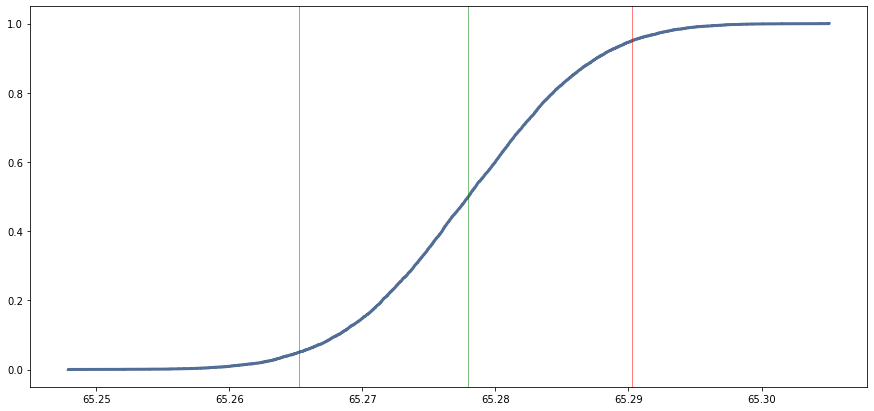

In [30]:
#Produce estimates - change the n and trials and observe results
mu = df["height"].mean()
sigma = df["height"].std()
n = df["height"].count()

cdf, ci, stderr,pmf = simulateNormal(mu=mu, sigma=sigma, n=n, m=10000, ciLow=5, ciHi=95)
print('Emperical mean: ', mu)
print("Standard Error:", stderr)
print("Low CI:", ci[0])
print("Hi CI:", ci[1])
print("Mean of Means:", cdf.Mean())
thinkplot.Cdf(cdf)
thinkplot.axvline(cdf.Mean(), color="green")
thinkplot.axvline(ci[0], color="red")
thinkplot.axvline(ci[1], color="red")
thinkplot.Config()

<AxesSubplot:ylabel='Density'>

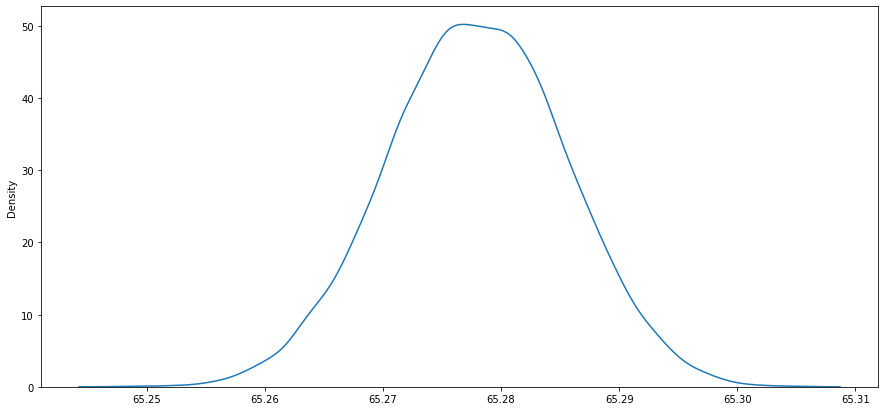

In [32]:
sns.kdeplot(pmf)

<h2>We Have an Estimate!</h2>

![Thanks Obama](images/thanks_obama.gif "Thanks Obama")

Where are we?

We took our sample of height and tried to use it to estimate the overall population's height parameter. 
Our sample looks pretty normal visually, so we generalized from the normal distribution in our data to the normal distribution of the population. 
We computed the relevant statistics to act as estimators for this inference - mean and standard devitation. 
We assumed that those statistics translated to the population, and used them to create an analytical normal distribution with those properties.
We ran multiple trials of creating a distribution at random, and tracked the results, yeilding...

- A measure of the standard error - our sample differed from the theoretical by a certain amount, on average.

- A multitude of predictions for the distribution, and the resulting mean, plotted in our cdf/pmf chart.

- Confidence intervals, where the middle 90% of our expected means will lie. 

Overall, this particular estimation looks pretty solid. Our data is pretty normal, the mean and median are quite similar. When running trials, we get a fairly constrained range of confidence intervals and the standard error is low (a real evaluation of "low" requires some domain knowledge) 
What does this mean? As long as the sample that we took was actually representitive of the population data, this estimation is likely quite good!

(We've done an OK job estimating the height of the female population of Estonia!)


<h2>Error</h2>

Above, we determined how much error we can expect in our estimate, but we only accounted for the <b>Sampling Error</b> - or error due to dealing with a limited subset of data. We can also look at this as, "given the data we have, how accurate/reliable of an estimate can we make?". In addition to this, there are other sources of error, we can't control them here!
<h3>Sampling Bias</h3>
Sampling Bias is error due to the fact that our sample that we have been given could be off, or non-representative. It is impossible to get a truly random sample of the population, so some error is introduced here. Maybe the areas where we got responses were richer than average, so they have better nutrition, so they are taller... Maybe the people who answered the phone are older than average and have started shrinking, etc... The actual sample we get will hopefully closely match the population, and statisticians take a lot of care to both ensure this and compensate for it, but it will never be perfect. 
<h3>Measurement Error</h3>
Measurement Error comes from issues with collecting the data. Meaurements aren't perfect, people who respond to surveys don't always give perfect data, people meauring their heights round up, etc... No matter what we are measuring, we rarely have perfectly accurate data going in, that introduces some error. 

We can attempt to reduce the sampling error, but the other two may overwhelm it! 

<br><br>

### Results in "Polling Language"

<b>"This Poll is Accurate to within 2.4%, 19 times out of 20..."</b>

If we want to express our results in a political poll style format...

In [25]:
#Expressed in terms of +/- 19 times out of 20, like polling results
middle = round((ci[0]+ci[1])/2, 3)
plusMin = round(ci[1]-middle, 3)
print("Average person is: "+str(middle)+" Inches Tall +/- "+str(plusMin)+", 18 times out of 20.")

#Why 18/20? We have the middle 90% (from 5% to 95%) for the CI range. 18/20 = 90%

Average person is: 65.278 Inches Tall +/- 0.013, 18 times out of 20.


<AxesSubplot:ylabel='Density'>

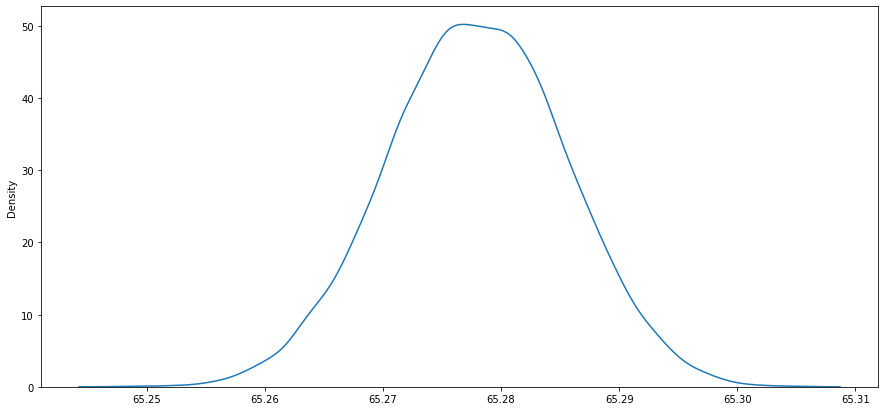

In [31]:
sns.kdeplot(pmf)

#### Results

This is our generalization - we have taken the height data, used it to estimate for the entire population, and calculated how much error we can reasonably expect in doing so!

## Exercise - How big are brains?

<b>Note:</b> There's a sample solution in the sol file, and this follows the same basic pattern as the example above. Try to attempt it without having steps defined as much as possible, and refer back to those or unmute and ask me if there's an issue. 

We can look at another one, brain size. Obviously gettting actual real brains to measure isn't the most practical, given the whole 'skull' thing getting in the way. 

##### Try to Calculate the Average Brain Weight of the Population and the 90% Confidence Intervals

In [35]:
def simulateNormal(mu=0, sigma=1, n=100, m=10000, ciLow=5, ciHi=95):
    means = []
    for j in range(m):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        means.append(xbar)
    cdf = thinkstats2.Cdf(means)

    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi)
    muList = [mu] * m
    stderr = mean_squared_error(means, muList, squared=False)# is squared is false we get RMSE and if it is true you get RMS

    return cdf, ci, stderr

In [36]:
#Load the data
#Also relabel the column, for ease of typing
brain = pd.read_csv("data/brain.csv")
brain = brain.rename(columns={"Brain Weight(grams)":"Weight", "Head Size(cm^3)":"Size"})
brain.head()

,Gender,Age Range,Size,Weight
0,1,1,4512,1530
1,1,1,3738,1297
2,1,1,4261,1335
3,1,1,3777,1282
4,1,1,4177,1590


In [37]:
#Take a peek at the varaibles
brain.describe()

,Gender,Age Range,Size,Weight
count,237.000000,237.000000,237.000000,237.000000
mean,1.434599,1.535865,3633.991561,1282.873418
std,0.496753,0.499768,365.261422,120.340446
min,1.000000,1.000000,2720.000000,955.000000
25%,1.000000,1.000000,3389.000000,1207.000000
50%,1.000000,2.000000,3614.000000,1280.000000
75%,2.000000,2.000000,3876.000000,1350.000000
max,2.000000,2.000000,4747.000000,1635.000000


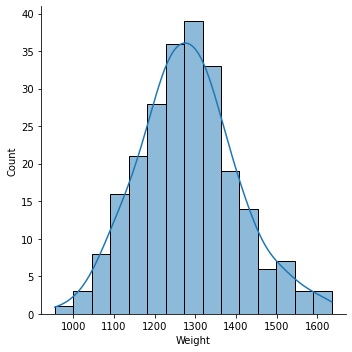

In [38]:
#visualize the distribution
sns.displot(data=brain, x="Weight", kde=True)

Looks pretty normal. We can use this knowledge to estimate the brain size of everyone!!!!

In [39]:
#Get some basic brain stats and save them in varaibles.
#mean, standard dev, median, and count. 
mu2 = brain["Weight"].mean()
sigma2 = brain["Weight"].std()
n2 = brain["Weight"].count()
med2 = brain["Weight"].median()

print("Mean:", mu2)
print("Med:", med2)
print("Std:", sigma2)
print("N:", n2)

Mean: 1282.873417721519
Med: 1280.0
Std: 120.34044578645724
N: 237


Create some distributions based on the stats we just calculated, run some trial runs. We could do the estimator trials here to see if we get any better estimators. 

Standard Error: 7.84867605771856
Low CI: 1266.7002477013882
Hi CI: 1298.843719540823
Estimate: 1282.886965970427


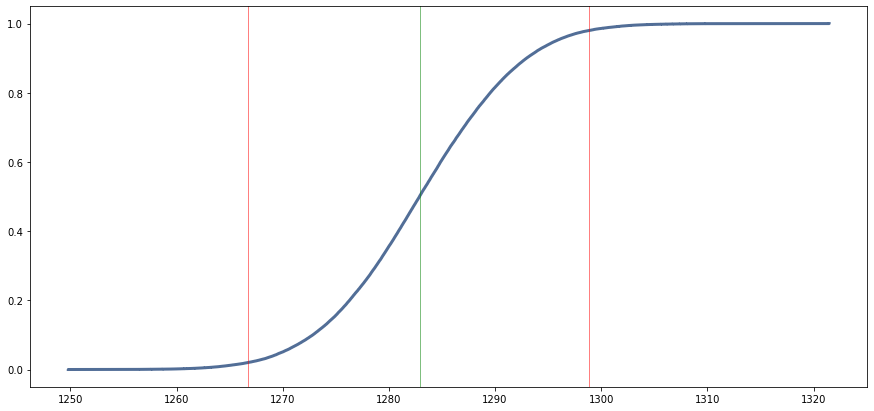

In [41]:
#Generate some trials using the normal simulator like last time. we are 96% confident that it is in that range 
#Print the error, confidence intervals, and graph. 
cdf2, ci2, stderr2 = simulateNormal(mu=mu2, sigma=sigma2, n=n2, m=100000, ciLow=2, ciHi=98)
print("Standard Error:", stderr2)
print("Low CI:", ci2[0])
print("Hi CI:", ci2[1])
print("Estimate:", cdf2.Mean())
thinkplot.Cdf(cdf2)
thinkplot.axvline(cdf2.Mean(), color="green")
thinkplot.axvline(ci2[0], color="red")
thinkplot.axvline(ci2[1], color="red")

What can we conclude about the brain size of the population as a whole based on this? How is our estimate? 

<h2>Exponential Distributions</h2>
Normal distributions are probably the most common, but we can apply the same process to other distributions. 

E.g. Exponential - We just need to adjust the creation of the distribution's random varaibles. 
<ul>
<li>Note: If you're doing this with an odd distribution, and the paramaters are not as simple as "mean", the easiest self check is to create the CDF and PDF of your data, then create the same of the sample data (with a large n), and compare. They should be reasonably close to each other. If the analytical random one is more or less the same as the original data, you probably haven't made a fundamental mistake
</ul>

For an exponential distribution we only need the mean to generate the analytical ones. The value that we actually need is generally labeled lambda, but it is just 1/mean so we can calculate it. 


In [17]:
#Exponential simulator
def simulateExp(mean=1, n=100, m=10000, ciLow=5, ciHi=95):
    means = []
    for j in range(m):
        xs = np.random.exponential(1/mean,n)
        xbar = 1/np.mean(xs)
        means.append(xbar)
    cdf = thinkstats2.Cdf(means)
    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi)
    rateList = [mean] * m
    stderr = mean_squared_error(means, rateList, squared=False)
    return cdf, ci, stderr

The exponential simulation is basically the same as the normal one. We just need to do the appropriate work to create an exponential distribution instead of a normal one. 

Standard Error: 0.85136101230869
Low CI: 1.2977969783787617
Hi CI: 3.8411355039437516
Estimate: 2.260277573262105


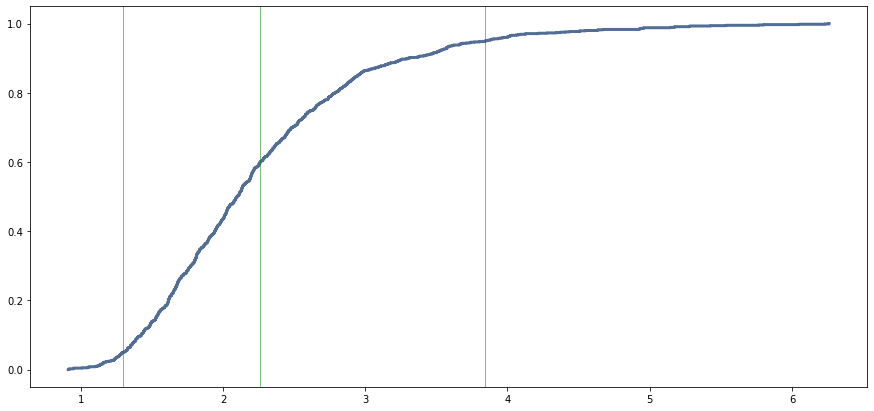

In [18]:
#Run a dummy one.... 
cdf3, ci3, stderr3 = simulateExp(mean=2, n=10, m=1000, ciLow=5, ciHi=95)
print("Standard Error:", stderr3)
print("Low CI:", ci3[0])
print("Hi CI:", ci3[1])
print("Estimate:", cdf3.Mean())
thinkplot.Cdf(cdf3)
thinkplot.axvline(cdf3.Mean(), color="green")
thinkplot.axvline(ci3[0], color="red")
thinkplot.axvline(ci3[1], color="red")
thinkplot.Config()

#### Results

Note the estimate here isn't dead center between the two CI lines like we saw with normal distributions above. The exponential distribution is not symetrical, so we don't get the same pattern. 

<h3>Real example - Load employee dataset</h3>

We are going to look at the column "stag" - it is a measure of how long an employee stays at a job. It is roughly exponential like the interarrival time in chapter 5. In terms of total numbers, most people quit right away, then it kind of flattens out. 

The stag value is in months of employment. 

<b>How long should we expect a typical employee to last?</b>

In [19]:
dfEmp = pd.read_csv("data/turnover.csv",encoding = "ISO-8859-1")
dfEmp.describe()

,stag,event,age,extraversion,independ,selfcontrol,anxiety,novator
count,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000
mean,36.627526,0.505757,31.066965,5.592383,5.478034,5.597254,5.665633,5.879628
std,34.096597,0.500188,6.996147,1.851637,1.703312,1.980101,1.709176,1.904016
min,0.394251,0.000000,18.000000,1.000000,1.000000,1.000000,1.700000,1.000000
25%,11.728953,0.000000,26.000000,4.600000,4.100000,4.100000,4.800000,4.400000
50%,24.344969,1.000000,30.000000,5.400000,5.500000,5.700000,5.600000,6.000000
75%,51.318275,1.000000,36.000000,7.000000,6.900000,7.200000,7.100000,7.500000
max,179.449692,1.000000,58.000000,10.000000,10.000000,10.000000,10.000000,10.000000


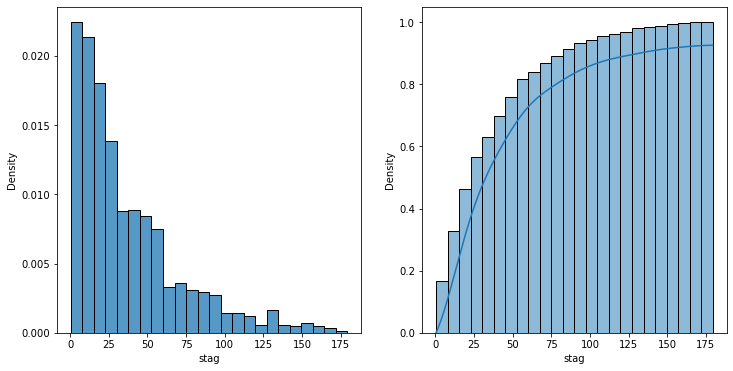

In [20]:
#Look at the distribution 
thinkplot.PrePlot(2,1,2)
sns.histplot(dfEmp["stag"], stat="density")
thinkplot.SubPlot(2)
sns.histplot(dfEmp["stag"], stat="density", cumulative=True, kde=True)
thinkplot.Config()

In [21]:
#Average time at a job - Looks ok. 
meanExp = dfEmp["stag"].mean()
countExp = dfEmp["stag"].count()
meanExp, countExp

(36.62752558551998, 1129)

##### Looks kind of exponentially distributed! Let's get it!!

<b>Note:</b> There are lots of distributions, and sometimes one may look like, "oh, this actually looks like X distribution". The ideas behind all of this stuff is the same no matter the distribution, we focus on normal (and varieties) because it is common, and other common different ones like exponential. Expanding this to other data that fits different distributions differs only in the mechanics. 

Estimate: 36.66069009609596
Standard Error: 1.0924199544543574
Low CI: 35.27585433084246
Hi CI: 38.07077888332808
Estimate to CI distance: 1.3848357652534986 -1.4100887872321195


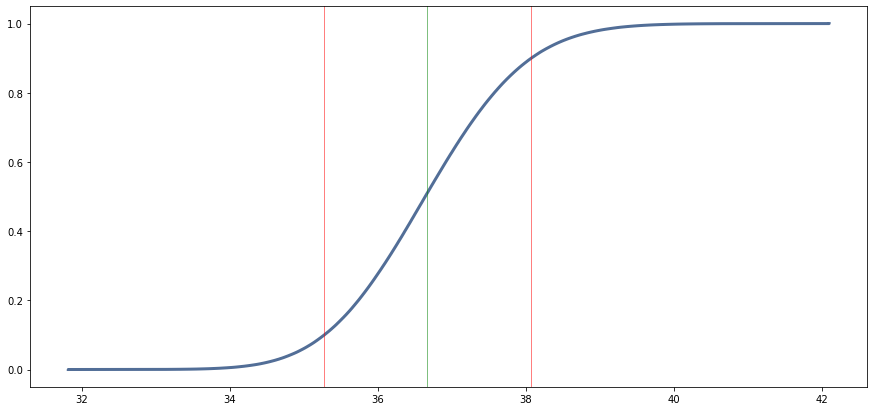

In [22]:
#Create exponential samples using the above function. 
cdfEmp, ciEmp, stderrEmp = simulateExp(mean=meanExp, n=countExp, m=1000000, ciLow=10, ciHi=90)
print("Estimate:", cdfEmp.Mean())
print("Standard Error:", stderrEmp)
print("Low CI:", ciEmp[0])
print("Hi CI:", ciEmp[1])
print("Estimate to CI distance:", cdfEmp.Mean()-ciEmp[0], cdfEmp.Mean()-ciEmp[1])
thinkplot.Cdf(cdfEmp)
thinkplot.axvline(cdfEmp.Mean(), color="green")
thinkplot.axvline(ciEmp[0], color="red")
thinkplot.axvline(ciEmp[1], color="red")
thinkplot.Config()

Look reasonable?